# 决策树

***优点:*** 计算复杂度不高，输出结果易于理解，对中间值的缺失不敏感，可以处理不相关特征数据  
***缺点:*** 可能产生过拟合问题  
***适用数据类型:*** 数值型和标称型

### 创建分支的伪代码
createBranch()
```
检测数据集中的每个子项是否属于同一分类：
  If so return 类标签;
  Else
     寻找划分数据集的最好特征
     划分数据集
     创建分支节点
        for 每个划分的子集
          调用函数createBranch并增加返回结果到分支节点中
     return 分支节点
```

### ID3算法
使用信息增益与信息熵来寻找划分数据集的最好特征  
***缺点*** 无法直接处理数值型数据

###### 香农熵
信息  
$l(x_i) = -\log_2p(x_i)\quad其中p(x_i)为该分类的概率$  
熵: 所有类别所有可能值包含的信息期望  
$H=-\sum_{i=i}^np(x_i)\log_2p(x_i)$

In [1]:
from math import log
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    # 为所有可能分类创建字典
    labelCounts = {}
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob*log(prob, 2)
    return shannonEnt

测试数据

In [2]:
myDat = [[1,1,'yes'],[1,1,'yes'],[1,0,'no'],[0,1,'no'],[0,1,'no']]

In [3]:
calcShannonEnt(myDat)

0.9709505944546686

###### 划分数据集

按照给定特征划分数据集

In [4]:
def splitDataSet(dataSet, axis, value):
    '''
    :dataSet 数据集
    :axis 划分数据的特征
    :value 需要返回的特征值
    '''
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

测试

In [5]:
splitDataSet(myDat,0,1)

[[1, 'yes'], [1, 'yes'], [0, 'no']]

选择最好的数据集划分方法

In [6]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) -1
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0
    bestFeature = -1
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        # 创建唯一的分类标签列表
        uniqueVals = set(featList)
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            # 计算每种划分方式的信息熵
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob*calcShannonEnt(subDataSet)
        infoGain = baseEntropy - newEntropy
        # 计算最好的信息增益
        if (infoGain > bestInfoGain):
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature

测试

In [7]:
chooseBestFeatureToSplit(myDat)

0

###### 递归构建决策树
递归终止条件
* 遍历完所有划分数据集的属性
* 每个分支下的的所有实例都具有相同的分类

如果数据集属性遍历完但类别标签不唯一，通常使用多数表决的方法决定叶子节点的分类

In [8]:
import operator
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

创建树

In [9]:
def createTree(dataSet, labels):
    # dataSet的最后一列表示类别
    classList = [example[-1] for example in dataSet]
    # 类别完全相同则停止继续划分
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    # 遍历完所有特征时返回出现次数最多的
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    # 获得列表所包含的所有属性值
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
    return myTree

测试

In [10]:
labels = ['no surfacing', 'flippers']

In [11]:
myTree = createTree(myDat, labels)
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

### 绘制树形图

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

# 定义文本框和箭头格式
decisionNode = dict(boxstyle='sawtooth', fc='0.8')
leafNode =  dict(boxstyle='round4', fc='0.8')
arrow_args = dict(arrowstyle='<-')

获取叶节点的数目

In [13]:
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        # 字典->子树结构
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

获取树的深度

In [14]:
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        # 字典->子树结构
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth

plotTree

In [15]:
# 绘制带箭头的注解
def plotNode(nodeText, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeText, xy=parentPt, xycoords='axes fraction', xytext=centerPt,\
                           textcoords='axes fraction', va='center', ha='center', bbox=nodeType,\
                           arrowprops=arrow_args)
# 在父子节点间填充文本信息
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)
    
def plotTree(myTree, parentPt, nodeText):
    # 计算宽高
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeText)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD #减小y偏移
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
    
# 主函数
def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

测试

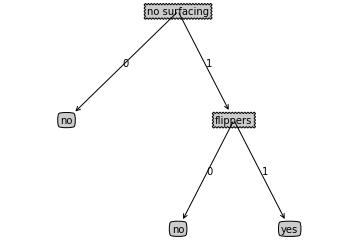

In [16]:
createPlot(myTree)

### 使用决策树执行分类

In [17]:
def classify(inputTree, featLables, testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    # 将feature标签转化为输入的索引
    featIndex = featLables.index(firstStr)
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key], featLables, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel

测试

In [18]:
labels = ['no surfacing', 'flippers']
classify(myTree, labels, [1,0])

'no'

### 模型存储

In [19]:
def storeTree(inputTree, filename):
    import pickle
    with open(filename, 'wb') as fw:
        pickle.dump(inputTree, fw)
        
def grabTree(filename):
    import pickle
    with open(filename, 'rb') as fr:
        return pickle.load(fr)

测试

In [20]:
storeTree(myTree, 'classifierStoreage.txt')
grabTree('classifierStoreage.txt')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

### 实例：预测隐形眼镜类型

In [21]:
import pandas as pd

In [22]:
lensesLabels = ['age','prescript','astigmatic','tearRate', 'lenses']
lenses = pd.read_csv("data/lenses.txt", sep='\t', engine='python', header=None, names=lensesLabels).values.tolist()

In [23]:
lensesTree = createTree(lenses, lensesLabels)

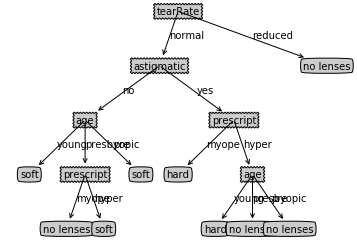

In [24]:
createPlot(lensesTree)